In [1]:
%%capture
import sys
!pip install tensorflow-addons
!pip install tslearn
!git clone https://github.com/ICascha/QuantGANs-replication.git
!unzip QuantGANs-replication/trained_models/trained_generator_SP500 -d QuantGANs-replication/trained_models
sys.path.append('/content/QuantGANs-replication/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from backend.tcn import make_TCN
from tensorflow.keras.utils import Progbar
from google.colab import files

In [3]:
dilations = 2**(np.arange(6))
block_size = 1
rfs = block_size * sum(dilations) + 1
n_filters = 10

In [4]:
N = 10
M = 100
epochs = 50
scores = []
scores_per_lag = []

progress = Progbar(rfs*N)

for j in range(rfs):

    for i in range(N):
        
        model = make_TCN(dilations, n_filters, 0, False, False, False, [1, rfs, 1], block_size=block_size)
        
        X = np.zeros((M, 1, rfs, 1))
        X[:, :, [-1, -(j+1)]] = np.random.randint(-25, 25, (M, 1, 2, 1)).astype('float32')   
        y = X[:, :, [-1, -(j+1)]].sum(axis=2)
        model.compile(optimizer='Adam', loss='mse')
        model.fit(X, y, epochs=epochs, verbose=False)
        
        X = np.zeros((M, 1, rfs, 1))
        X[:, :, [-1, -(j+1)]] = np.random.randint(-25, 25+1, (M, 1, 2, 1)).astype('float32')   
        y = X[:, :, [-1, -(j+1)]].sum(axis=2)
        
        scores.append(np.mean(np.abs(y.ravel() - model.predict(X).ravel())))

    progress.update((j+1)*(i + 1))
    
    scores_per_lag.append(sum(scores)/N)
    scores = []

640/640 [==============================] - 4138s 6s/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

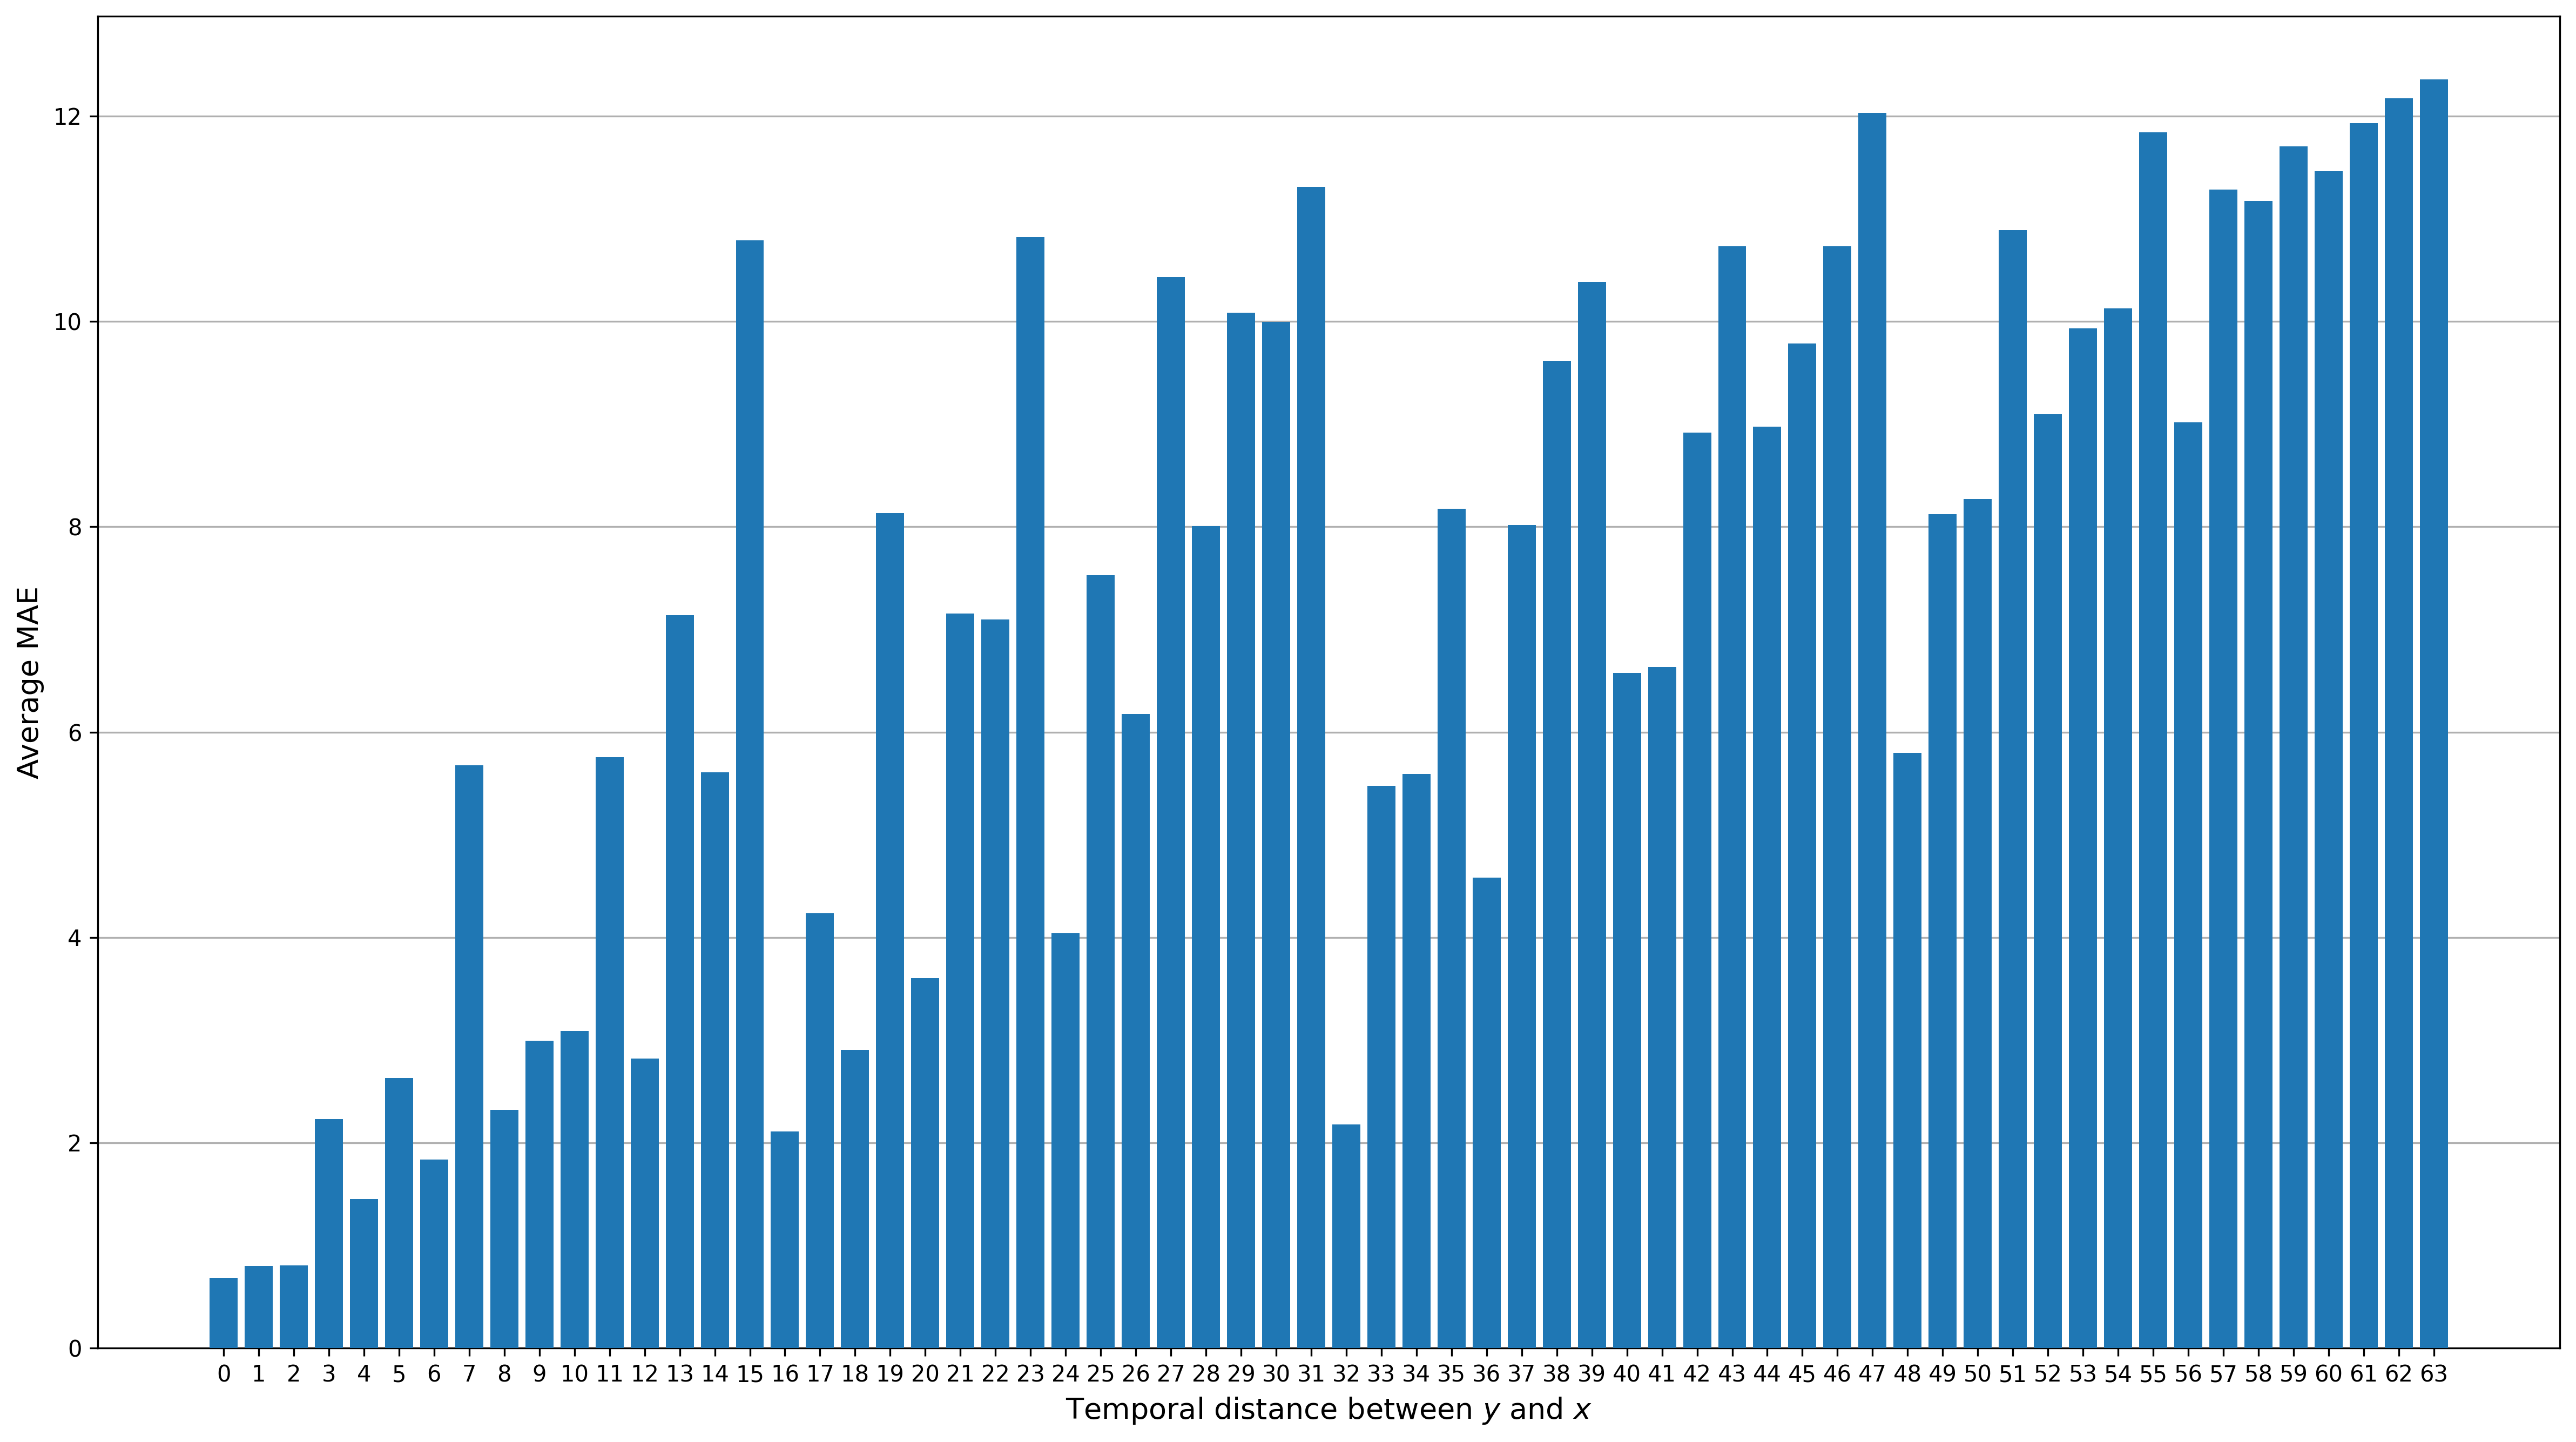

In [5]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
ax.yaxis.grid(zorder=0)
plt.bar(np.arange(len(scores_per_lag)), scores_per_lag, zorder=3)
ax.set_ylabel('Average MAE', size=13)
ax.set_xlabel('Temporal distance between $y$ and $x$', size=13)
ax.set_xticks(np.arange(64))
plt.tight_layout()


plt.savefig('mae_tcn_experiment.png', dpi=500)
files.download("mae_tcn_experiment.png");

In [6]:
# local minima
np.where((np.array(scores_per_lag)[1:] - np.array(scores_per_lag)[:-1]) < 0)[0] + 1

array([ 4,  6,  8, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 36, 40, 44,
       48, 52, 56, 58, 60])